In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from power.systems import *


In [2]:
results_118 = Path("results_ieee118")
files_118 = list(results_118.glob("*.json"))
results_b6l8 = Path("results_b6l8")
files_b6l8 = list(results_b6l8.glob("*.json"))

In [3]:
def criar_dataframes_separados(results_dir: str = "results_b6l8") -> dict:
    """
    Lê todos os arquivos JSON de resultados, os processa e retorna um
    dicionário de DataFrames, cada um contendo uma parte específica dos dados.

    Args:
        results_dir (str): O nome da pasta contendo os arquivos .json.

    Returns:
        dict: Um dicionário onde as chaves são os nomes das tabelas e os
        valores são os DataFrames correspondentes.
    """
    results_path = Path(results_dir)
    files = sorted(list(results_path.glob("*.json")), key=lambda f: int(f.stem.split('_')[-1]))

    if not files:
        print(f"ERRO: Nenhum arquivo .json encontrado em '{results_dir}'.")
        return {}

    # Inicializa listas para armazenar os dados de cada futuro DataFrame
    sumario_list = []
    geracao_list = []
    fluxo_list = []
    cargas_list = []
    perdas_barra_list = []
    lmp_list = []
    congestionamento_list = []
    curtailment_individual_list = []
    
    print(f"Processando {len(files)} arquivos de resultado...")

    for filepath in files:
        with open(filepath) as f:
            data = json.load(f)

        if data.get('solver_status') != 'Optimal':
            continue
            
        cenario_id = int(filepath.stem.split('_')[-1])

        curtailment_data = {}
        for gen_id, values in data['sumario_curtailment']['curtailment_por_gerador'].items():
            # A chave será 'gerador_1', 'gerador_2', etc.
            curtailment_data[f'gerador_{gen_id}'] = float(values['curtailment_pu'])
        curtailment_data['cenario_id'] = cenario_id
        curtailment_individual_list.append(curtailment_data)

        # 1. Tabela de Sumário
        sumario_list.append({
            'cenario_id': cenario_id,
            'custo_total': float(data['custo_total'].replace('$', '')),
            'carga_total_pu': float(data['sumario_perdas']['carga_total_pu']),
            'perdas_totais_pu': float(data['sumario_perdas']['perdas_totais_pu']),
            'curtailment_total_pu': float(data['sumario_curtailment']['curtailment_total_pu'])
            
        })

        # 2. Tabela de Geração (inclui corte de carga)
        geracao_data = {f'gerador_{k}': float(v) for k, v in data['primal_results']['geracao_pu'].items()}
        geracao_data['cenario_id'] = cenario_id
        geracao_list.append(geracao_data)

        # 3. Tabela de Fluxos nas Linhas
        fluxo_data = {f'linha_{k}': float(v) for k, v in data['primal_results']['fluxo_pu'].items()}
        fluxo_data['cenario_id'] = cenario_id
        fluxo_list.append(fluxo_data)

        # 4. Tabela de Cargas Individuais
        cargas_data = {f'carga_{k}': float(v) for k, v in data['sumario_perdas']['cargas_individuais_pu'].items()}
        cargas_data['cenario_id'] = cenario_id
        cargas_list.append(cargas_data)
        
        # 5. Tabela de Perdas por Barra
        perdas_data = {f'barra_{k}': float(v) for k, v in data['sumario_perdas']['perdas_por_barra_pu'].items()}
        perdas_data['cenario_id'] = cenario_id
        perdas_barra_list.append(perdas_data)
        
        # 6. Tabela de Custo Marginal (LMP)
        lmp_data = {f'barra_{k}': v.replace('$', '').replace('/pu', '') for k, v in data['dual_results']['custo_marginal_de_energia_LMP'].items()}
        lmp_data['cenario_id'] = cenario_id
        lmp_list.append(lmp_data)
        
        # 7. Tabela de Congestionamento (Lagrange)
        cong_data = {}
        for line_id, values in data['dual_results']['congestionamento_de_fluxo'].items():
            cong_data[f'linha_{line_id}_sup'] = float(values['limite_superior'])
            cong_data[f'linha_{line_id}_inf'] = float(values['limite_inferior'])
        cong_data['cenario_id'] = cenario_id
        congestionamento_list.append(cong_data)

    # Cria o dicionário de DataFrames
    dataframes = {
        'sumario': pd.DataFrame(sumario_list).set_index('cenario_id'),
        'geracao': pd.DataFrame(geracao_list).set_index('cenario_id'),
        'fluxo': pd.DataFrame(fluxo_list).set_index('cenario_id'),
        'cargas': pd.DataFrame(cargas_list).set_index('cenario_id'),
        'perdas_barra': pd.DataFrame(perdas_barra_list).set_index('cenario_id'),
        'lmp': pd.DataFrame(lmp_list).set_index('cenario_id').astype(float),
        'congestionamento': pd.DataFrame(congestionamento_list).set_index('cenario_id'),
        'curtailment_individual': pd.DataFrame(curtailment_individual_list).set_index('cenario_id') 
    }

    print("Dicionário de DataFrames criado com sucesso!")
    return dataframes

## B6L8

In [4]:
# Chama a função para criar o dicionário de DataFrames
dfs = criar_dataframes_separados(results_dir="results_b6l8")

if dfs:
    # Exibe as primeiras linhas de cada DataFrame criado
    for nome, df in dfs.items():
        print(f"\n--- Tabela: {nome} ---")
        print(df.head())

    # Exemplo de como salvar a tabela de geração em um arquivo CSV
    dfs['geracao'].to_csv("geracao_por_cenario.csv")
    print("\nTabela 'geracao' salva como geracao_por_cenario.csv")

Processando 100 arquivos de resultado...
Dicionário de DataFrames criado com sucesso!

--- Tabela: sumario ---
            custo_total  carga_total_pu  perdas_totais_pu  \
cenario_id                                                  
0              18652.88          1.6740            0.0017   
1              32221.03          1.6612            0.0025   
2              51885.97          1.6513            0.0025   
3              20110.89          1.6421            0.0012   
4              13529.17          1.6167            0.0035   

            curtailment_total_pu  
cenario_id                        
0                            0.0  
1                           -0.0  
2                            0.0  
3                           -0.0  
4                           -0.0  

--- Tabela: geracao ---
            gerador_1  gerador_2  gerador_3  gerador_1001  gerador_1002  \
cenario_id                                                                
0              0.3870     0.3072     0.51

### FOB Média

In [5]:
df_sumario = dfs['sumario']

# --- 2. Calcula a média das colunas desejadas ---
# A FOB (Função Objetivo) está na coluna 'custo_total'
fob_media = df_sumario['custo_total'].mean()

# As perdas totais estão na coluna 'perdas_totais_pu'
perdas_totais_media = df_sumario['perdas_totais_pu'].mean()

# --- 3. Apresenta os Resultados ---
print("--- Análise de Custo e Perdas Médias ---")
# O ':,.2f' formata o número com separador de milhar e duas casas decimais
print(f"FOB Média (Custo Total Médio): ${fob_media:,.2f}")
print(f"Perdas Totais Médias:           {perdas_totais_media:.4f} pu")

--- Análise de Custo e Perdas Médias ---
FOB Média (Custo Total Médio): $30,319.34
Perdas Totais Médias:           0.0022 pu


### Cálculo de MVU e MVD

In [6]:
df_geracao = dfs['geracao']

# 2. Filtra as colunas para incluir apenas os geradores reais (IDs < 1000)
# Isso exclui os geradores de déficit (corte de carga) da análise de rampa.
colunas_geradores_reais = [
    col for col in df_geracao.columns
    if int(col.split('_')[1]) < 1000
]

df_geracao_real = df_geracao[colunas_geradores_reais]

diferencas = df_geracao_real.diff()

mvu = diferencas.max()
mvd = -diferencas.min()

# 5. Apresenta os resultados de forma organizada
df_rampas = pd.DataFrame({
    'MVU (pu)': mvu,
    'MVd (pu)': mvd
})

print("--- Maiores Rampas de Geração (MVU e MVd) ---")
print(df_rampas)


--- Maiores Rampas de Geração (MVU e MVd) ---
           MVU (pu)  MVd (pu)
gerador_1    0.4082    0.3977
gerador_2    0.6126    0.6223
gerador_3    0.5337    0.4533



Gerador com maior MVU: gerador_2 (Valor: 0.6126 pu)
Gerador com maior MVd: gerador_2 (Valor: 0.6223 pu)

Gráfico salvo com sucesso como 'grafico_rampas_geradores.png'


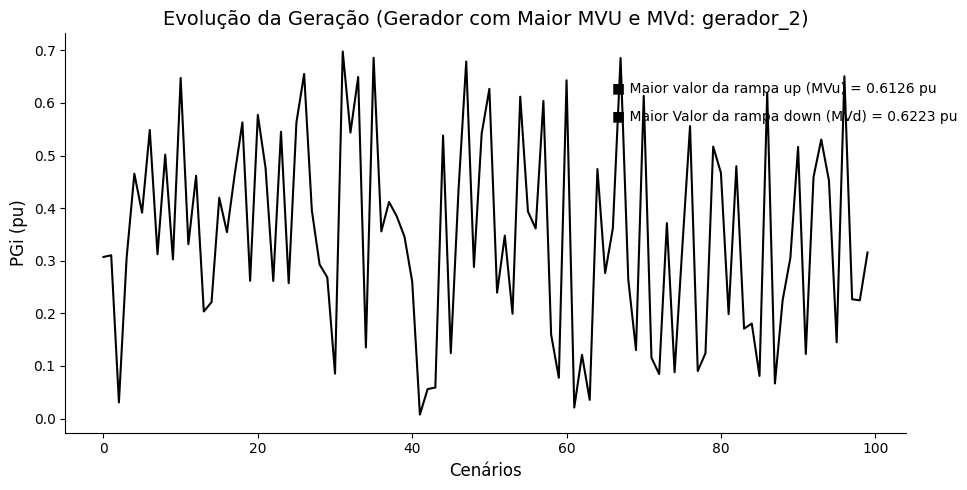

In [7]:
# --- INÍCIO DA GERAÇÃO DOS GRÁFICOS ---

# 1. Encontra o ID do gerador com o maior MVU e maior MVd
gen_maior_mvu = df_rampas['MVU (pu)'].idxmax()
gen_maior_mvd = df_rampas['MVd (pu)'].idxmax()

print(f"\nGerador com maior MVU: {gen_maior_mvu} (Valor: {df_rampas.loc[gen_maior_mvu, 'MVU (pu)']:.4f} pu)")
print(f"Gerador com maior MVd: {gen_maior_mvd} (Valor: {df_rampas.loc[gen_maior_mvd, 'MVd (pu)']:.4f} pu)")

# 2. Prepara os dados para o gráfico
dados_gen_mvu = df_geracao_real[gen_maior_mvu]
dados_gen_mvd = df_geracao_real[gen_maior_mvd]
cenarios = df_geracao_real.index

# 3. Gera os gráficos
plt.style.use('default') # Estilo mais próximo ao da imagem

# Verifica se os geradores são os mesmos para decidir se faz 1 ou 2 gráficos
if gen_maior_mvu == gen_maior_mvd:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(cenarios, dados_gen_mvu, color='black', marker='', linestyle='-')
    ax.set_title(f'Evolução da Geração (Gerador com Maior MVU e MVd: {gen_maior_mvu})', fontsize=14)
    ax.set_xlabel('Cenários', fontsize=12)
    ax.set_ylabel('PGi (pu)', fontsize=12)
    
    # Remove as bordas do gráfico para ficar mais parecido com a imagem
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adiciona anotações no gráfico
    ax.text(0.65, 0.85, f'■ Maior valor da rampa up (MVu) = {df_rampas.loc[gen_maior_mvu, "MVU (pu)"]:.4f} pu', transform=ax.transAxes)
    ax.text(0.65, 0.78, f'■ Maior Valor da rampa down (MVd) = {df_rampas.loc[gen_maior_mvd, "MVd (pu)"]:.4f} pu', transform=ax.transAxes)

else: # Caso os geradores sejam diferentes, cria dois subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
    
    # Gráfico para o gerador com maior MVU
    axs[0].plot(cenarios, dados_gen_mvu, color='black', marker='', linestyle='-')
    axs[0].set_title(f'Evolução da Geração - Gerador com Maior MVU ({gen_maior_mvu})', fontsize=14)
    axs[0].set_ylabel('PGi (pu)', fontsize=12)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].text(0.65, 0.85, f'■ Maior valor da rampa up (MVu) = {df_rampas.loc[gen_maior_mvu, "MVU (pu)"]:.4f} pu', transform=axs[0].transAxes)

    # Gráfico para o gerador com maior MVd
    axs[1].plot(cenarios, dados_gen_mvd, color='black', marker='', linestyle='-')
    axs[1].set_title(f'Evolução da Geração - Gerador com Maior MVd ({gen_maior_mvd})', fontsize=14)
    axs[1].set_xlabel('Cenários', fontsize=12)
    axs[1].set_ylabel('PGi (pu)', fontsize=12)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].text(0.65, 0.85, f'■ Maior Valor da rampa down (MVd) = {df_rampas.loc[gen_maior_mvd, "MVd (pu)"]:.4f} pu', transform=axs[1].transAxes)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Salva a imagem em um arquivo
output_filename = 'grafico_rampas_geradores.png'
plt.savefig(output_filename, dpi=300)
print(f"\nGráfico salvo com sucesso como '{output_filename}'")

# Mostra o gráfico na tela
plt.show()

### Curtailment

In [8]:
curtailment_medio_gerador = dfs['curtailment_individual']
print(curtailment_medio_gerador)

            gerador_1  gerador_2  gerador_3
cenario_id                                 
0                 0.0       -0.0        0.0
1                -0.0       -0.0        0.0
2                 0.0        0.0        0.0
3                -0.0        0.0       -0.0
4                -0.0       -0.0       -0.0
...               ...        ...        ...
95                0.0        0.0        0.0
96               -0.0        0.0        0.0
97                0.0       -0.0       -0.0
98                0.0       -0.0        0.0
99               -0.0        0.0       -0.0

[100 rows x 3 columns]


O curtailment total médio do sistema foi de 0.001587pu
--- Curtailment Médio por Gerador Eólico ---
gerador_1   0.0016
gerador_2   0.0000
gerador_3   0.0000

Gráfico salvo com sucesso como 'grafico_curtailment_por_gerador.png'


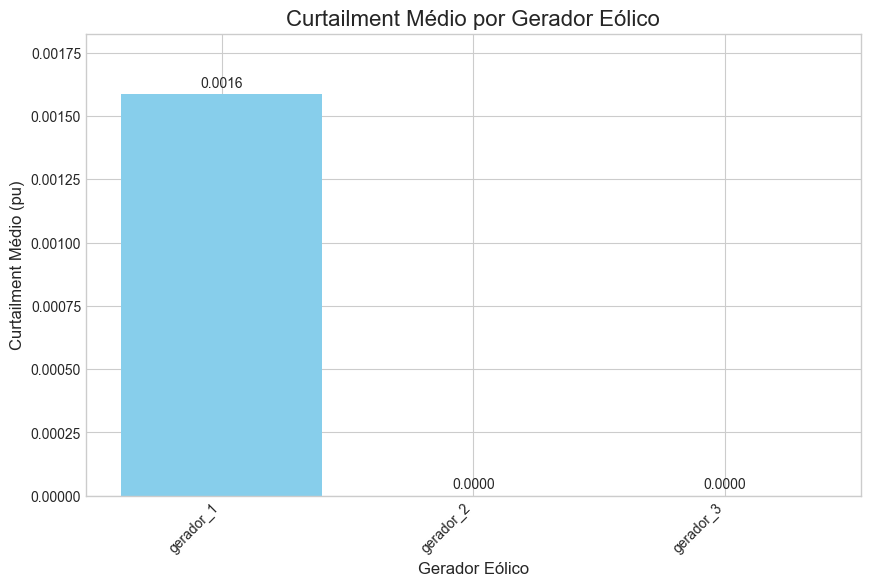

In [9]:
curtailment_medio = dfs['sumario']['curtailment_total_pu'].mean()
print(f"O curtailment total médio do sistema foi de {curtailment_medio}pu")

curtailment_medio_gerador = dfs['curtailment_individual'].mean()
# Ordena os resultados para identificar facilmente os geradores mais afetados
ranking_curtailment = curtailment_medio_gerador.sort_values(ascending=False)

print("--- Curtailment Médio por Gerador Eólico ---")
print(ranking_curtailment.to_string(float_format="%.4f"))


# --- 3. Crie o Gráfico de Barras ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Usa o ranking para plotar as barras da maior para a menor
bars = ax.bar(ranking_curtailment.index, ranking_curtailment.values, color='skyblue')

# Adiciona o valor numérico em cima de cada barra
ax.bar_label(bars, fmt='%.4f', padding=3)

# Configurações do gráfico
ax.set_title('Curtailment Médio por Gerador Eólico', fontsize=16)
ax.set_xlabel('Gerador Eólico', fontsize=12)
ax.set_ylabel('Curtailment Médio (pu)', fontsize=12)
ax.set_ylim(top=ranking_curtailment.max() * 1.15) # Ajusta o limite superior do eixo Y
plt.xticks(rotation=45, ha="right") # Rotaciona os nomes dos geradores se forem muitos

# Salva a imagem
output_filename = 'grafico_curtailment_por_gerador.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"\nGráfico salvo com sucesso como '{output_filename}'")

# Mostra o gráfico
plt.show()

### Corte de Carga

In [10]:
df_geracao = dfs['geracao']

carga_total_media = dfs['sumario']['carga_total_pu'].mean()
print(f"A carga total média é de: {carga_total_media} pu")

# b. Identificamos as colunas dos geradores de déficit (assumindo IDs > 1000).
colunas_corte_carga = [
    col for col in df_geracao.columns
    if int(col.split('_')[1]) > 1000
]

# c. Somamos o corte de carga de todas as colunas de déficit para cada cenário (linha).
corte_carga_por_cenario = df_geracao[colunas_corte_carga].sum(axis=1)

# c. Somamos o corte de carga de todas as colunas de déficit para cada cenário (linha).
corte_carga_por_cenario = df_geracao[colunas_corte_carga].sum(axis=1)

corte_carga_medio = corte_carga_por_cenario.mean()
print(f"O corte de carga médio foi de {corte_carga_medio} pu")

corte_porcento = corte_carga_medio / carga_total_media

print(f"A porcentagem de carga cortada foi em média {corte_porcento*100:.3f}%")


A carga total média é de: 1.6416859999999998 pu
O corte de carga médio foi de 0.7579879999999999 pu
A porcentagem de carga cortada foi em média 46.171%


### Linhas Estranguladas

In [11]:
try:
    net_base = B6L8EOL()
    line_id_to_name = {
        line.id: f'Linha {line.from_bus.id} -> {line.to_bus.id}'
        for line in net_base.lines
    }
    print("Mapeamento de IDs de linha para nomes criado com sucesso.")
except Exception as e:
    print(f"AVISO: Não foi possível criar o mapeamento de nomes de linha. Usando IDs numéricos. Erro: {e}")
    line_id_to_name = {}

# --- 1. Seleciona o DataFrame de congestionamento ---
df_congestionamento = dfs['congestionamento']

# --- 2. Calcula a média de cada multiplicador ---
media_congestionamento = df_congestionamento.mean()

# --- 3. Agrupa por linha e soma as médias dos limites ---
line_ids_str = sorted(list(set([col.split('_')[1] for col in df_congestionamento.columns])))

soma_lagrange_por_linha = {}
for line_id_str in line_ids_str:
    # Converte o ID da string para inteiro para usar no mapa
    line_id_int = int(line_id_str)
    
    # --- MODIFICAÇÃO PRINCIPAL ---
    # Busca o nome descritivo no mapa. Se não encontrar, usa o nome padrão.
    nome_descritivo = line_id_to_name.get(line_id_int, f'Linha_{line_id_int}')
    
    media_sup = abs(media_congestionamento.get(f'linha_{line_id_str}_sup', 0))
    media_inf = abs(media_congestionamento.get(f'linha_{line_id_str}_inf', 0))
    soma_lagrange_por_linha[nome_descritivo] = media_sup + media_inf

# --- 4. Ordena os resultados para criar um ranking ---
series_lagrange_medio = pd.Series(soma_lagrange_por_linha)
ranking_linhas = series_lagrange_medio.sort_values(ascending=False)

# --- 5. Apresenta os Resultados com os Nomes Corretos ---
print("\n--- Resposta ao item 2 do exercício (com nomes de barra) ---")
print("Ranking de Linhas por Influência no Custo (Lagrange Médio):\n")
print(ranking_linhas.to_string(float_format="%.6f"))

if not ranking_linhas.empty:
    linha_mais_influente = ranking_linhas.index[0]
    valor_maximo = ranking_linhas.iloc[0]

    print(f"\n==> A LT que mais influenciou o acréscimo na FOB foi a {linha_mais_influente},")
    print(f"    com um valor de Lagrange médio de {valor_maximo:.6f}.")
else:
    print("\nNenhuma linha apresentou congestionamento médio significativo.")


Mapeamento de IDs de linha para nomes criado com sucesso.

--- Resposta ao item 2 do exercício (com nomes de barra) ---
Ranking de Linhas por Influência no Custo (Lagrange Médio):

Linha 1 -> 2   2524.240380
Linha 1 -> 5   2000.000000
Linha 3 -> 4    222.012150
Linha 2 -> 3      0.000000
Linha 5 -> 6      0.000000
Linha 4 -> 2      0.000000
Linha 4 -> 5      0.000000
Linha 3 -> 6      0.000000

==> A LT que mais influenciou o acréscimo na FOB foi a Linha 1 -> 2,
    com um valor de Lagrange médio de 2524.240380.


## IEEE118

In [12]:
# Chama a função para criar o dicionário de DataFrames
dfs = criar_dataframes_separados(results_dir="results_ieee118")

if dfs:
    # Exibe as primeiras linhas de cada DataFrame criado
    for nome, df in dfs.items():
        print(f"\n--- Tabela: {nome} ---")
        print(df.head())

    # Exemplo de como salvar a tabela de geração em um arquivo CSV
    dfs['geracao'].to_csv("geracao_por_cenario.csv")
    print("\nTabela 'geracao' salva como geracao_por_cenario.csv")

Processando 100 arquivos de resultado...
Dicionário de DataFrames criado com sucesso!

--- Tabela: sumario ---
            custo_total  carga_total_pu  perdas_totais_pu  \
cenario_id                                                  
0             311613.70         37.4404            0.8140   
1             310288.69         37.2454            0.8348   
2             322944.23         37.7209            0.8394   
3             329359.51         37.8106            0.8515   
4             320054.42         37.5276            0.8423   

            curtailment_total_pu  
cenario_id                        
0                            0.0  
1                            0.0  
2                           -0.0  
3                            0.0  
4                           -0.0  

--- Tabela: geracao ---
            gerador_1  gerador_2  gerador_3  gerador_4  gerador_5  gerador_6  \
cenario_id                                                                     
0                 1.3     0.149

### FOB 

In [13]:
df_sumario = dfs['sumario']

# --- 2. Calcula a média das colunas desejadas ---
# A FOB (Função Objetivo) está na coluna 'custo_total'
fob_media = df_sumario['custo_total'].mean()

# As perdas totais estão na coluna 'perdas_totais_pu'
perdas_totais_media = df_sumario['perdas_totais_pu'].mean()

# --- 3. Apresenta os Resultados ---
print("--- Análise de Custo e Perdas Médias ---")
# O ':,.2f' formata o número com separador de milhar e duas casas decimais
print(f"FOB Média (Custo Total Médio): ${fob_media:,.2f}")
print(f"Perdas Totais Médias:           {perdas_totais_media:.4f} pu")

--- Análise de Custo e Perdas Médias ---
FOB Média (Custo Total Médio): $319,800.21
Perdas Totais Médias:           0.8322 pu


### MVU E MVD

In [14]:
df_geracao = dfs['geracao']

# 2. Filtra as colunas para incluir apenas os geradores reais (IDs < 1000)
# Isso exclui os geradores de déficit (corte de carga) da análise de rampa.
colunas_geradores_reais = [
    col for col in df_geracao.columns
    if int(col.split('_')[1]) < 1000
]

df_geracao_real = df_geracao[colunas_geradores_reais]

diferencas = df_geracao_real.diff()

mvu = diferencas.max()
mvd = -diferencas.min()

# 5. Apresenta os resultados de forma organizada
df_rampas = pd.DataFrame({
    'MVU (pu)': mvu,
    'MVd (pu)': mvd
})

print("--- Maiores Rampas de Geração (MVU e MVd) ---")
print(df_rampas)


--- Maiores Rampas de Geração (MVU e MVd) ---
            MVU (pu)  MVd (pu)
gerador_1     0.0000   -0.0000
gerador_2     0.2289    0.1445
gerador_3     0.0000   -0.0000
gerador_4     0.0882    0.0800
gerador_5     0.0000   -0.0000
...              ...       ...
gerador_61    0.1701    0.1899
gerador_62    0.0751    0.0928
gerador_63    0.1458    0.1440
gerador_64    0.0948    0.0702
gerador_65    0.1616    0.1617

[65 rows x 2 columns]



Gerador com maior MVU: gerador_22 (Valor: 0.3490 pu)
Gerador com maior MVd: gerador_22 (Valor: 0.4216 pu)

Gráfico salvo com sucesso como 'grafico_rampas_geradores.png'


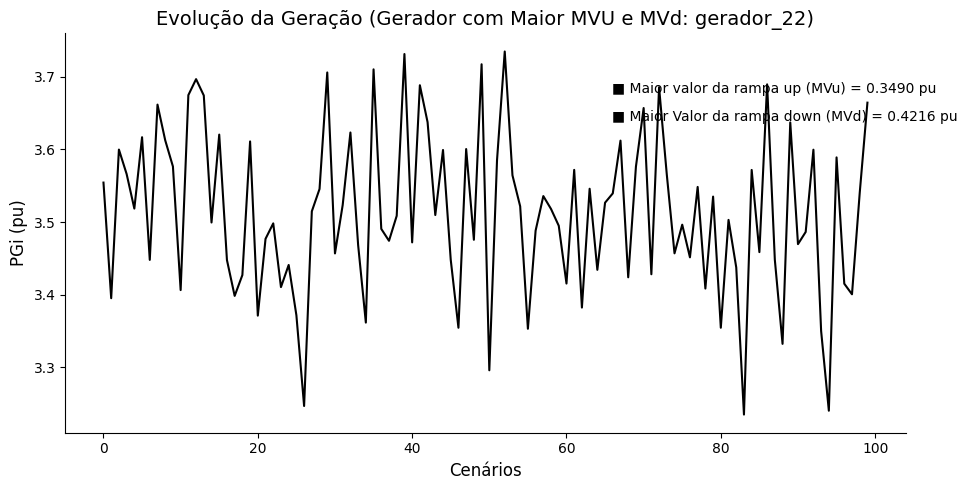

In [15]:
# --- INÍCIO DA GERAÇÃO DOS GRÁFICOS ---

# 1. Encontra o ID do gerador com o maior MVU e maior MVd
gen_maior_mvu = df_rampas['MVU (pu)'].idxmax()
gen_maior_mvd = df_rampas['MVd (pu)'].idxmax()

print(f"\nGerador com maior MVU: {gen_maior_mvu} (Valor: {df_rampas.loc[gen_maior_mvu, 'MVU (pu)']:.4f} pu)")
print(f"Gerador com maior MVd: {gen_maior_mvd} (Valor: {df_rampas.loc[gen_maior_mvd, 'MVd (pu)']:.4f} pu)")

# 2. Prepara os dados para o gráfico
dados_gen_mvu = df_geracao_real[gen_maior_mvu]
dados_gen_mvd = df_geracao_real[gen_maior_mvd]
cenarios = df_geracao_real.index

# 3. Gera os gráficos
plt.style.use('default') # Estilo mais próximo ao da imagem

# Verifica se os geradores são os mesmos para decidir se faz 1 ou 2 gráficos
if gen_maior_mvu == gen_maior_mvd:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(cenarios, dados_gen_mvu, color='black', marker='', linestyle='-')
    ax.set_title(f'Evolução da Geração (Gerador com Maior MVU e MVd: {gen_maior_mvu})', fontsize=14)
    ax.set_xlabel('Cenários', fontsize=12)
    ax.set_ylabel('PGi (pu)', fontsize=12)
    
    # Remove as bordas do gráfico para ficar mais parecido com a imagem
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adiciona anotações no gráfico
    ax.text(0.65, 0.85, f'■ Maior valor da rampa up (MVu) = {df_rampas.loc[gen_maior_mvu, "MVU (pu)"]:.4f} pu', transform=ax.transAxes)
    ax.text(0.65, 0.78, f'■ Maior Valor da rampa down (MVd) = {df_rampas.loc[gen_maior_mvd, "MVd (pu)"]:.4f} pu', transform=ax.transAxes)

else: # Caso os geradores sejam diferentes, cria dois subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)
    
    # Gráfico para o gerador com maior MVU
    axs[0].plot(cenarios, dados_gen_mvu, color='black', marker='', linestyle='-')
    axs[0].set_title(f'Evolução da Geração - Gerador com Maior MVU ({gen_maior_mvu})', fontsize=14)
    axs[0].set_ylabel('PGi (pu)', fontsize=12)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].text(0.65, 0.85, f'■ Maior valor da rampa up (MVu) = {df_rampas.loc[gen_maior_mvu, "MVU (pu)"]:.4f} pu', transform=axs[0].transAxes)

    # Gráfico para o gerador com maior MVd
    axs[1].plot(cenarios, dados_gen_mvd, color='black', marker='', linestyle='-')
    axs[1].set_title(f'Evolução da Geração - Gerador com Maior MVd ({gen_maior_mvd})', fontsize=14)
    axs[1].set_xlabel('Cenários', fontsize=12)
    axs[1].set_ylabel('PGi (pu)', fontsize=12)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].text(0.65, 0.85, f'■ Maior Valor da rampa down (MVd) = {df_rampas.loc[gen_maior_mvd, "MVd (pu)"]:.4f} pu', transform=axs[1].transAxes)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Salva a imagem em um arquivo
output_filename = 'grafico_rampas_geradores.png'
plt.savefig(output_filename, dpi=300)
print(f"\nGráfico salvo com sucesso como '{output_filename}'")

# Mostra o gráfico na tela
plt.show()

### Curtailment

O curtailment total médio do sistema foi de 0.0pu
--- Curtailment Médio por Gerador Eólico ---
gerador_55   0.0000
gerador_56   0.0000
gerador_57   0.0000
gerador_58   0.0000
gerador_59   0.0000
gerador_60   0.0000
gerador_61   0.0000
gerador_62   0.0000
gerador_63   0.0000
gerador_64   0.0000
gerador_65   0.0000

Gráfico salvo com sucesso como 'grafico_curtailment_por_gerador.png'


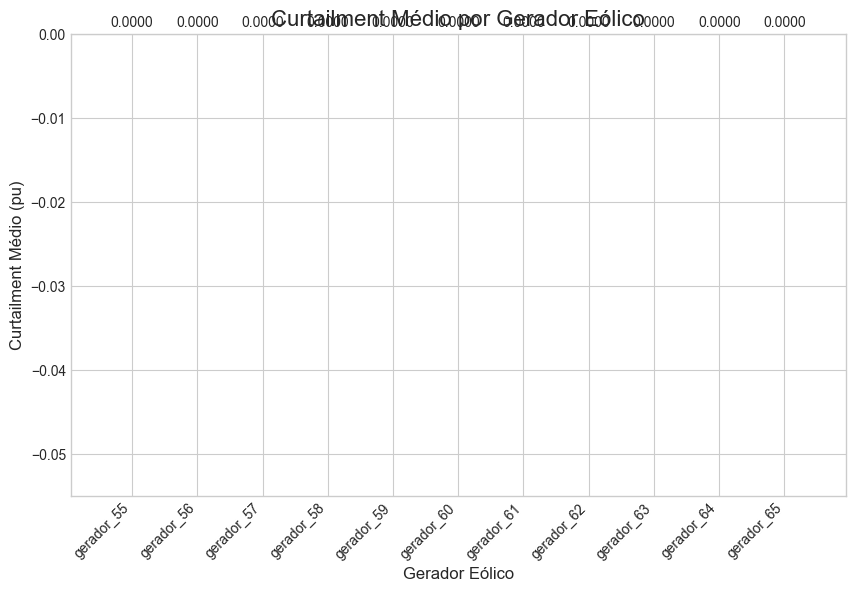

In [16]:
curtailment_medio = dfs['sumario']['curtailment_total_pu'].mean()
print(f"O curtailment total médio do sistema foi de {curtailment_medio}pu")

curtailment_medio_gerador = dfs['curtailment_individual'].mean()
# Ordena os resultados para identificar facilmente os geradores mais afetados
ranking_curtailment = curtailment_medio_gerador.sort_values(ascending=False)

print("--- Curtailment Médio por Gerador Eólico ---")
print(ranking_curtailment.to_string(float_format="%.4f"))


# --- 3. Crie o Gráfico de Barras ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Usa o ranking para plotar as barras da maior para a menor
bars = ax.bar(ranking_curtailment.index, ranking_curtailment.values, color='skyblue')

# Adiciona o valor numérico em cima de cada barra
ax.bar_label(bars, fmt='%.4f', padding=3)

# Configurações do gráfico
ax.set_title('Curtailment Médio por Gerador Eólico', fontsize=16)
ax.set_xlabel('Gerador Eólico', fontsize=12)
ax.set_ylabel('Curtailment Médio (pu)', fontsize=12)
ax.set_ylim(top=ranking_curtailment.max() * 1.15) # Ajusta o limite superior do eixo Y
plt.xticks(rotation=45, ha="right") # Rotaciona os nomes dos geradores se forem muitos

# Salva a imagem
output_filename = 'grafico_curtailment_por_gerador.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"\nGráfico salvo com sucesso como '{output_filename}'")

# Mostra o gráfico
plt.show()

### Corte de Carga médio

In [17]:
df_geracao = dfs['geracao']

carga_total_media = dfs['sumario']['carga_total_pu'].mean()
print(f"A carga total média é de: {carga_total_media} pu")

# b. Identificamos as colunas dos geradores de déficit (assumindo IDs > 1000).
colunas_corte_carga = [
    col for col in df_geracao.columns
    if int(col.split('_')[1]) > 1000
]

# c. Somamos o corte de carga de todas as colunas de déficit para cada cenário (linha).
corte_carga_por_cenario = df_geracao[colunas_corte_carga].sum(axis=1)

# c. Somamos o corte de carga de todas as colunas de déficit para cada cenário (linha).
corte_carga_por_cenario = df_geracao[colunas_corte_carga].sum(axis=1)

corte_carga_medio = corte_carga_por_cenario.mean()
print(f"O corte de carga médio foi de {corte_carga_medio} pu")

corte_porcento = corte_carga_medio / carga_total_media

print(f"A porcentagem de carga cortada foi em média {corte_porcento*100:.3f}%")




A carga total média é de: 37.59035300000001 pu
O corte de carga médio foi de 2.862543 pu
A porcentagem de carga cortada foi em média 7.615%


## Linha que mais impactou no custo da operação

In [18]:
try:
    net_base = IEEE118EOL()
    line_id_to_name = {
        line.id: f'Linha {line.from_bus.id} -> {line.to_bus.id}'
        for line in net_base.lines
    }
    print("Mapeamento de IDs de linha para nomes criado com sucesso.")
except Exception as e:
    print(f"AVISO: Não foi possível criar o mapeamento de nomes de linha. Usando IDs numéricos. Erro: {e}")
    line_id_to_name = {}

# --- 1. Seleciona o DataFrame de congestionamento ---
df_congestionamento = dfs['congestionamento']

# --- 2. Calcula a média de cada multiplicador ---
media_congestionamento = df_congestionamento.mean()

# --- 3. Agrupa por linha e soma as médias dos limites ---
line_ids_str = sorted(list(set([col.split('_')[1] for col in df_congestionamento.columns])))

soma_lagrange_por_linha = {}
for line_id_str in line_ids_str:
    # Converte o ID da string para inteiro para usar no mapa
    line_id_int = int(line_id_str)
    
    # --- MODIFICAÇÃO PRINCIPAL ---
    # Busca o nome descritivo no mapa. Se não encontrar, usa o nome padrão.
    nome_descritivo = line_id_to_name.get(line_id_int, f'Linha_{line_id_int}')
    
    media_sup = abs(media_congestionamento.get(f'linha_{line_id_str}_sup', 0))
    media_inf = abs(media_congestionamento.get(f'linha_{line_id_str}_inf', 0))
    soma_lagrange_por_linha[nome_descritivo] = media_sup + media_inf

# --- 4. Ordena os resultados para criar um ranking ---
series_lagrange_medio = pd.Series(soma_lagrange_por_linha)
ranking_linhas = series_lagrange_medio.sort_values(ascending=False)

# --- 5. Apresenta os Resultados com os Nomes Corretos ---
print("\n--- Resposta ao item 2 do exercício (com nomes de barra) ---")
print("Ranking de Linhas por Influência no Custo (Lagrange Médio):\n")
print(ranking_linhas.to_string(float_format="%.6f"))

if not ranking_linhas.empty:
    linha_mais_influente = ranking_linhas.index[0]
    valor_maximo = ranking_linhas.iloc[0]

    print(f"\n==> A LT que mais influenciou o acréscimo na FOB foi a {linha_mais_influente},")
    print(f"    com um valor de Lagrange médio de {valor_maximo:.6f}.")
else:
    print("\nNenhuma linha apresentou congestionamento médio significativo.")


Mapeamento de IDs de linha para nomes criado com sucesso.

--- Resposta ao item 2 do exercício (com nomes de barra) ---
Ranking de Linhas por Influência no Custo (Lagrange Médio):

Linha 69 -> 75     78757.575050
Linha 8 -> 5       45976.781320
Linha 15 -> 19     44194.659680
Linha 23 -> 24     42140.620400
Linha 54 -> 56     41010.175030
Linha 15 -> 17     38916.574420
Linha 100 -> 103   35137.916390
Linha 64 -> 65     33012.910290
Linha 49 -> 66     17691.300840
Linha 8 -> 30      11880.061165
Linha 65 -> 68      3310.820961
Linha 55 -> 56      2742.585012
Linha 62 -> 67         0.000000
Linha 62 -> 66         0.000000
Linha 66 -> 67         0.000000
Linha 47 -> 69         0.000000
Linha 49 -> 69         0.000000
Linha 65 -> 66         0.000000
Linha 4 -> 11          0.000000
Linha 70 -> 75         0.000000
Linha 74 -> 75         0.000000
Linha 76 -> 77         0.000000
Linha 69 -> 77         0.000000
Linha 11 -> 12         0.000000
Linha 75 -> 77         0.000000
Linha 77 -> 78     